# **1 - Importando as bibliotecas e o dataset**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pathlib
import textwrap
from google.colab import userdata
from IPython.display import display
from IPython.display import Markdown
import pandas as pd
import nltk
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
nltk.download('all')
!pip install nltk
!pip install unidecode

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 7.7 MB/s eta 0:00:00


In [ ]:
#importando o DataSet Bruto
# ultrassom_df = pd.read_csv('/content/ultracheck_dataset_bruto.csv')

#importando o DataSet já tratado
ultrassom_df = pd.read_csv('/content/ultrassom_dataset_final.csv')

#Visualizando o DataSet
ultrassom_df.head()

NameError: name 'pd' is not defined

# 2 - Tratamento base de dados bruta

## **2.1 -Função de visualização da base de dados**

In [ ]:
def gerar_wordcloud_DF (Coluna_DF):

  from wordcloud import WordCloud

  #juntando todo o conteúdo da coluna em um texto só
  todas_palavras = ' '.join(Coluna_DF.tolist())

  #Construindo uma nuvem de palavras
  nuvem_palavra = WordCloud(width=800,
                            height=500,
                            max_font_size=110,
                            collocations=False
                            ).generate(todas_palavras)
  %matplotlib inline
  import matplotlib.pyplot as plt

  plt.figure(figsize=(10,7))
  plt.imshow(nuvem_palavra, interpolation='bilinear')
  plt.axis('off')
  plt.show()

In [ ]:
def gerar_pareto_DF (coluna_texto, quantidade):

    todas_palavras = ' '.join(coluna_texto.tolist())

    from nltk import tokenize
    token = tokenize.WordPunctTokenizer()

    tokens_texto = token.tokenize(todas_palavras)

    frequencia = nltk.FreqDist(tokens_texto)

    df_frequencia = pd.DataFrame({'Palavra':list(frequencia.keys()),
                                  'Frequencia':list(frequencia.values())
                                 })
    df_freq = df_frequencia.nlargest(columns='Frequencia', n=quantidade)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,8))

    import seaborn as sns
    ax= sns.barplot(data=df_freq, x='Palavra', y='Frequencia', color='gray')
    ax.set(ylabel = 'Contagem')
    plt.show()

In [ ]:
ultrassom_df['Corpus Completo'] = ultrassom_df['Sintomas']+' '+ultrassom_df['Laudo técnico']
ultrassom_df['Corpus Completo'].head()

,Corpus Completo
0,Desconforto ou Dor Abdominal; Fadiga ou Cansaç...
1,Fadiga e cansaço.Fraqueza geral.Perda de apeti...
2,Fadiga ou cansaço extremo.Mal-estar geral.Febr...
3,Cansaço ou fadiga. Mal-estar geral.Perda de ap...
4,Dor lombar intensa e súbita (geralmente unilat...


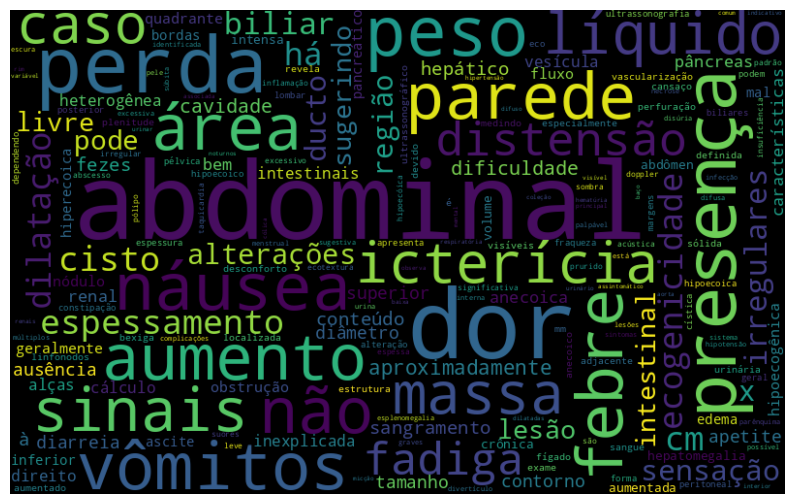

In [ ]:
gerar_wordcloud_DF(ultrassom_df['Corpus Completo'])

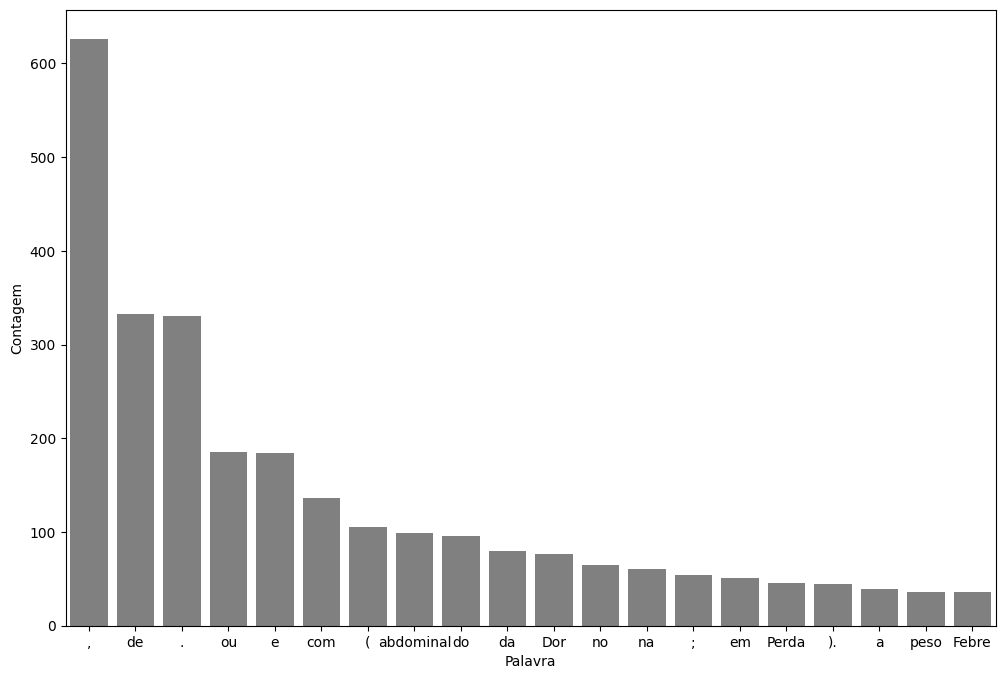

In [ ]:
gerar_pareto_DF(ultrassom_df['Corpus Completo'], 20)

## **2.2 - Funções para tratamento dos dados**

In [ ]:
def tokenizar (texto):

  from nltk import tokenize

  #instanciando um objeto tokenizador
  token = tokenize.WordPunctTokenizer()

  #aplicando a função tokenize
  texto_tokenizado = token.tokenize(texto)

  return texto_tokenizado

#Função para padronizar tudo para minúsculo
def transformar_minusculo (texto):
    texto_minusculo = texto.lower()
    return texto_minusculo

#Preparando uma função para retirar pontuações

def remover_pontuacao (texto):

  from string import punctuation
  pontuacao = [letra for letra in punctuation]

  from nltk import tokenize
  token = tokenize.WordPunctTokenizer()
  token_frase = token.tokenize(texto)

  Texto_limpo=[]
  for loop in token_frase:
    if loop not in pontuacao:
      Texto_limpo.append(loop)

  Texto_limpo_junto = ' '.join(Texto_limpo)

  return Texto_limpo_junto

def remover_acentos (texto):

    from unidecode import unidecode

    texto_sem_acentos = unidecode(texto)

    return texto_sem_acentos

#construindo função de remoção de StopWords
def remover_stopwords (texto):
  #como o texto não tem mais pontuação você pode usar o comando split() para tokenizar
    Texto_Tokenizado = texto.split()

    StopWords_Portugues = nltk.corpus.stopwords.words('portuguese')
    # Devemos retirar os acentos das stopwords também
    from unidecode import unidecode

    StopWords_Portugues_Sem_Acento = [unidecode(palavra) for palavra in StopWords_Portugues]

    Texto_limpo=[]
    for loop in Texto_Tokenizado:
        if loop not in StopWords_Portugues_Sem_Acento:
            Texto_limpo.append(loop)

    Texto_limpo_junto = ' '.join(Texto_limpo)

    return Texto_limpo_junto

def stemmerizar (texto):
    stemmer = nltk.RSLPStemmer()
    lista_palavras = texto.split()
    lista_texto_stemmerizado = [stemmer.stem(palavra) for palavra in lista_palavras]
    texto_stemmerizado = ' '.join(lista_texto_stemmerizado)
    return texto_stemmerizado

def tratar_texto(texto_0):
  texto_1 = transformar_minusculo(texto_0)
  texto_2 = remover_pontuacao(texto_1)
  texto_3 = remover_acentos(texto_2)
  texto_4 = remover_stopwords(texto_3)
  texto_5 = stemmerizar(texto_4)
  return texto_5

In [ ]:
ultrassom_df['Corpus Completo'] = ultrassom_df['Corpus Completo'].apply(transformar_minusculo)
ultrassom_df['Corpus Completo'] = ultrassom_df['Corpus Completo'].apply(remover_pontuacao)
ultrassom_df['Corpus Completo'] = ultrassom_df['Corpus Completo'].apply(remover_stopwords)

## **2.3 - Tratando os dados**

In [ ]:
ultrassom_df['Dados_tratados'] = ultrassom_df['Corpus Completo'].apply(tratar_texto)
# Visualizando o DataSet
ultrassom_df.head()

,Sintomas,Laudo técnico,Possível Diagnóstico,Corpus Completo,Dados_tratados
0,Desconforto ou Dor Abdominal; Fadiga ou Cansaç...,Aumento da Ecogenicidade do Fígado (Fígado Bri...,Esteatose Hepática.,Desconforto ou Dor Abdominal; Fadiga ou Cansaç...,desconfort dor abdom fadig cansac icteric hepa...
1,Fadiga e cansaço.Fraqueza geral.Perda de apeti...,Heterogeneidade do Parênquima Hepático;Aumento...,Cirrose Hepática,Fadiga e cansaço.Fraqueza geral.Perda de apeti...,fadig cansac fraqu geral perd apetit nause des...
2,Fadiga ou cansaço extremo.Mal-estar geral.Febr...,Aumento Difuso do Tamanho do Fígado (Hepatomeg...,Hepatite Aguda,Fadiga ou cansaço extremo.Mal-estar geral.Febr...,fadig cansac extr mal geral febr baix dor musc...
3,Cansaço ou fadiga. Mal-estar geral.Perda de ap...,"ecogenicidade aumentada, com aspecto granular ...",Hepatite Crônica,Cansaço ou fadiga. Mal-estar geral.Perda de ap...,cansac fadig mal geral perd apetit anorex ). n...
4,Dor lombar intensa e súbita (geralmente unilat...,Presença de cálculos (litíase) no interior do ...,Cálculos Renais (Litíase Renal),Dor lombar intensa e súbita (geralmente unilat...,"dor lomb intens subit geral unilater ), irradi..."


In [ ]:
#Caso seja necessário exportar a base de dados
ultrassom_df.to_csv('ultrasssom_final.csv', index=False)

# **3 - Executar caso utilize somente a base de dados final**

In [ ]:
ultrassom_df['Embeddings_TF'] = ultrassom_df['Embeddings_TF'].apply(eval)

# **4 - Intância do TfidfVectorizer**

In [ ]:
vectorizer = TfidfVectorizer()

In [ ]:
tfidf_matrix = vectorizer.fit_transform(ultrassom_df['Dados_tratados'])

ultrassom_df['Embeddings_TF'] = tfidf_matrix.toarray().tolist()

In [ ]:
ultrassom_df.head()

,Sintomas,Laudo técnico,Possível Diagnóstico,Corpus Completo,Dados_tratados,Embeddings_TF
0,Desconforto ou Dor Abdominal; Fadiga ou Cansaç...,Aumento da Ecogenicidade do Fígado (Fígado Bri...,Esteatose Hepática.,Desconforto ou Dor Abdominal; Fadiga ou Cansaç...,desconfort dor abdom fadig cansac icteric hepa...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0570204358872..."
1,Fadiga e cansaço.Fraqueza geral.Perda de apeti...,Heterogeneidade do Parênquima Hepático;Aumento...,Cirrose Hepática,Fadiga e cansaço.Fraqueza geral.Perda de apeti...,fadig cansac fraqu geral perd apetit nause des...,"[0.0, 0.0, 0.11862952571030437, 0.0, 0.0, 0.0,..."
2,Fadiga ou cansaço extremo.Mal-estar geral.Febr...,Aumento Difuso do Tamanho do Fígado (Hepatomeg...,Hepatite Aguda,Fadiga ou cansaço extremo.Mal-estar geral.Febr...,fadig cansac extr mal geral febr baix dor musc...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.12119227..."
3,Cansaço ou fadiga. Mal-estar geral.Perda de ap...,"ecogenicidade aumentada, com aspecto granular ...",Hepatite Crônica,Cansaço ou fadiga. Mal-estar geral.Perda de ap...,cansac fadig mal geral perd apetit anorex ). n...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0926548975234..."
4,Dor lombar intensa e súbita (geralmente unilat...,Presença de cálculos (litíase) no interior do ...,Cálculos Renais (Litíase Renal),Dor lombar intensa e súbita (geralmente unilat...,"dor lomb intens subit geral unilater ), irradi...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0362449483734..."


# **5 - Função de Diagnóstico**

In [ ]:
#Traz somente 1 resultado
def diagnosticar_with_tf(sintoma_paciente):
    sintoma_paciente = tratar_texto(sintoma_paciente)

    embedding_paciente = vectorizer.transform([sintoma_paciente]).toarray()

    similaridades = cosine_similarity(embedding_paciente, np.vstack(ultrassom_df['Embeddings_TF']))

    idx_max_similaridade = np.argmax(similaridades)

    return ultrassom_df.loc[idx_max_similaridade, ["Possível Diagnóstico"]].to_dict()

In [ ]:
#Traz 3 resultado possíveis
def diagnosticar(sintoma_paciente):
    sintoma_paciente = tratar_texto(sintoma_paciente)

    embedding_paciente = vectorizer.transform([sintoma_paciente]).toarray()

    similaridades = cosine_similarity(embedding_paciente, np.vstack(ultrassom_df['Embeddings_TF'])).flatten()

    top_indices = similaridades.argsort()[-3:][::-1]

    resultados = []
    for idx in top_indices:
        resultado = ultrassom_df.loc[idx, ["Possível Diagnóstico"]].to_dict()
        resultado["Similaridade"] = similaridades[idx]*100
        resultados.append(resultado)

    return resultados

# **6 - Testes**

Os testes devem ser feitos concatenando o sintoma + o laudo técnico

In [ ]:
sintoma_laudo_paciente = "Desconforto ou Dor Abdominal; Fadiga ou Cansaço; Icterícia; Hepatomegalia; Ascite Aumento da Ecogenicidade do Fígado (Fígado Brilhante); Dificuldade na Visualização das Estruturas Internas; Perda da Definição dos Vasos hepáticos;Aumento do Tamanho do Fígado (Hepatomegalia; Alteração Difusa ou Focal. "
resultado = diagnosticar(sintoma_laudo_paciente)
for i, diagnostico in enumerate(resultado, 1):
    print(f"Diagnóstico {i}:")
    print(f" - Doença: {diagnostico['Possível Diagnóstico']}")
    print(f" - Similaridade: {diagnostico['Similaridade']:.2f}%")

Diagnóstico 1:
 - Doença: Esteatose Hepática. 
 - Similaridade: 86.06%
Diagnóstico 2:
 - Doença: Hepatite Aguda
 - Similaridade: 41.56%
Diagnóstico 3:
 - Doença: Tumores Hepáticos
 - Similaridade: 36.67%


In [ ]:
sintoma_laudo_paciente2 = "dor abdominal em faixa nos flancos, que piora após comer. litíase em colédoco, espessamento de parede de vesíscula biliar, sinais inflamatórios em vesícula biliar e canal colédoco"
resultado2 = diagnosticar(sintoma_laudo_paciente2)
print(f"Possível doença:\n {resultado2['Possível Diagnóstico']}\n Similaridade: {resultado2['Similaridade']}")

Possível doença:
 Tumores das vias biliares. 
 Similaridade: 0.2666894592595293


In [ ]:
sintoma_laudo_paciente = "Sangue nas fezes, dificuldade respiratório. Irritabilidade.  Presença de pneumatosis intestinal com bolhas de ar visíveis na parede de alças intestinaisDistensão das alças intestinais com espessamento da parede intestinal"
resultado = diagnosticar(sintoma_laudo_paciente)
for i, diagnostico in enumerate(resultado, 1):
    print(f"Diagnóstico {i}:")
    print(f" - Doença: {diagnostico['Possível Diagnóstico']}")
    print(f" - Similaridade: {diagnostico['Similaridade']:.2f}%")

# **7 - Adicionando a interface do Gradio**

In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 90.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.8 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
import gradio as gr

In [ ]:
#Somente com 1 saída
def gradio_diagnosticar(sintomas, laudo):
    corpus = sintomas+laudo
    resultado = diagnosticar_with_tf(corpus)
    nome = resultado["Possível Diagnóstico"]
    return nome

demo = gr.Interface(
    fn=gradio_diagnosticar,
    inputs=[gr.TextArea(label = "Sintomas:"),
            gr.TextArea(label = "Laudo Técnico:")],
    outputs=[gr.TextArea(label = "Possível Doença:")],
    title="ULTRACHECK - Seu Sistema de Diagnóstico Médico Para Ultrassonografias",
    description="Digite os sintomas apresentados pelo paciente e o laudo técnico."
)

demo.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://191374db8b496eb262.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
#3 Saídas de possíveis diagnósticos
def gradio_diagnosticar(sintomas, laudo):
    corpus = sintomas+laudo
    resultados = diagnosticar(corpus)
    respostas = []
    respostas.append(f"=========================ULTRACHECK=========================\n")
    for i, resultado in enumerate(resultados, 1):
        nome = resultado["Possível Diagnóstico"]
        similaridade = resultado["Similaridade"]
        respostas.append(f"Diagnóstico {i}:\n - Possível doença: {nome}\n - Similaridade: {similaridade:.2f} %\n")

    return "\n\n".join(respostas)

demo = gr.Interface(
    fn=gradio_diagnosticar,
    inputs=[gr.TextArea(label = "Sintomas:"),
            gr.TextArea(label = "Laudo Técnico:")],
    outputs=[gr.TextArea(label = "Ultracheck Diagnóstico:")],
    title="ULTRACHECK - Seu Sistema de Diagnóstico Médico Para Ultrassonografias",
    description="Digite os sintomas apresentados pelo paciente e o laudo técnico."
)

demo.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://287ecc984440f1adf8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
